# Flask App.py

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://192.168.1.6:8080
Press CTRL+C to quit
192.168.1.6 - - [05/Feb/2025 21:41:18] "GET / HTTP/1.1" 200 -
192.168.1.6 - - [05/Feb/2025 21:41:20] "GET /favicon.ico HTTP/1.1" 404 -
C:\Users\91834\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\91834\AppData\Local\Temp\ipykernel_10968\3605251356.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Predicted Trips', 'Active Vehicles'], y=[prediction, active_vehicles], palette=['#ff9999', '#66b3ff'])
C:\Users\91834\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names,

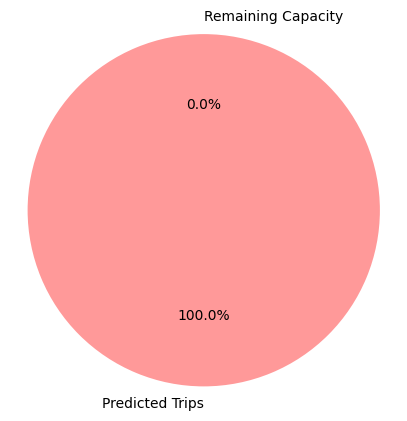

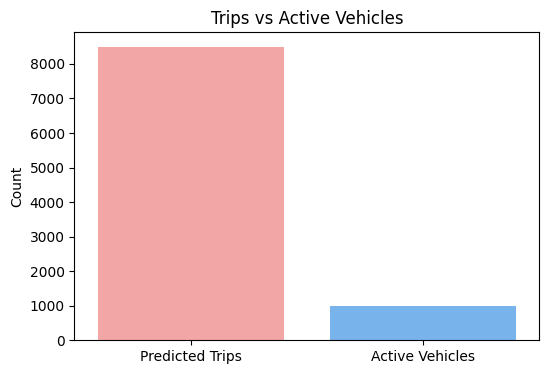

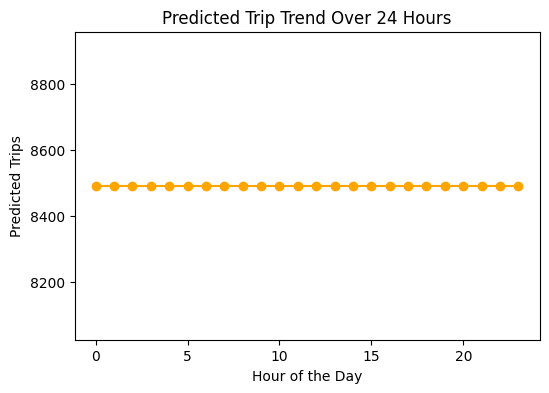

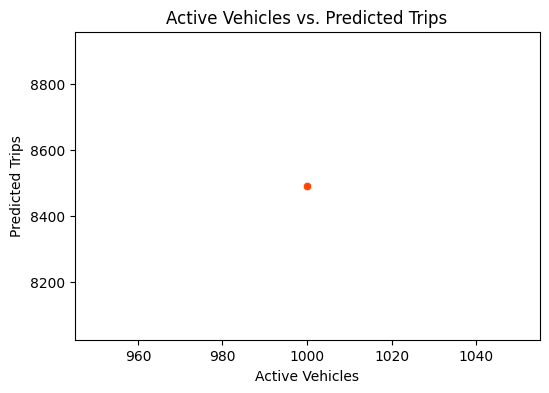

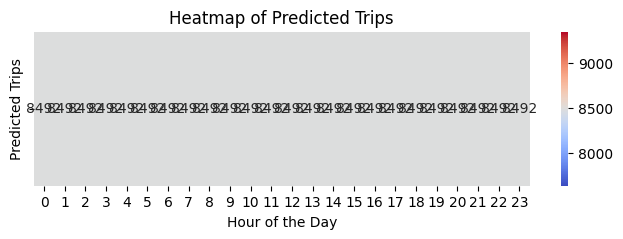

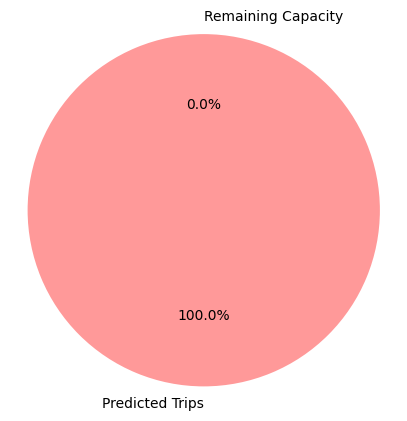

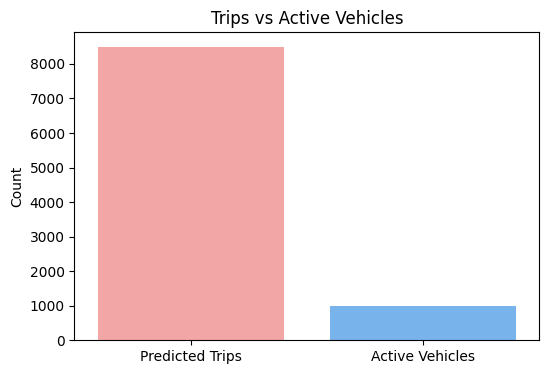

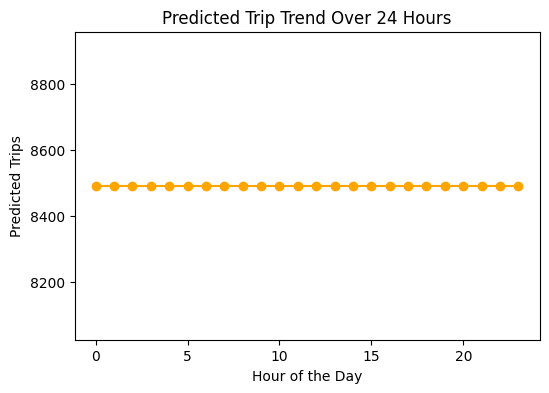

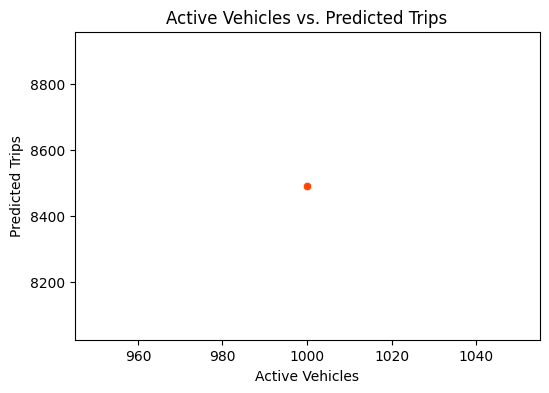

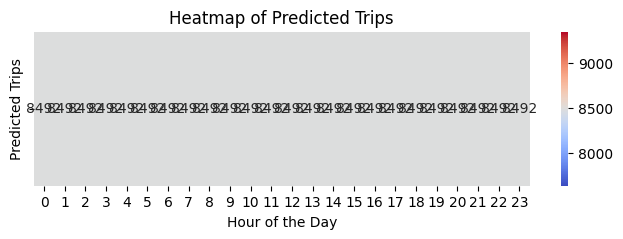

In [2]:
from flask import Flask, render_template, request
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import numpy as np
from datetime import datetime

# Initialize Flask app
app = Flask(__name__)

# Load the trained model
model = joblib.load("uber_trip_predictor_model.pkl")

def preprocess_input(date_time, active_vehicles):
    """Extracts features from date and time input."""
    date_time = pd.to_datetime(date_time)
    hour = date_time.hour
    day_of_week = date_time.weekday()
    month = date_time.month
    weekend = 1 if day_of_week >= 5 else 0  # 1 for weekend, 0 for weekdays
    return [[active_vehicles, hour, day_of_week, month, weekend]]

def generate_visualizations(active_vehicles, prediction, date_time):
    """Generate multiple visualizations including pie chart, bar graph, line chart, scatter plot, and heatmap."""
    img_pie, img_bar, img_line, img_scatter, img_heatmap = io.BytesIO(), io.BytesIO(), io.BytesIO(), io.BytesIO(), io.BytesIO()
    
    # Pie chart
    labels = ['Predicted Trips', 'Remaining Capacity']
    sizes = [prediction, max(0, active_vehicles - prediction)]
    colors = ['#ff9999','#66b3ff']
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.axis('equal')
    plt.savefig(img_pie, format='png')
    img_pie.seek(0)
    pie_url = base64.b64encode(img_pie.getvalue()).decode('utf8')
    
    # Bar graph
    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Predicted Trips', 'Active Vehicles'], y=[prediction, active_vehicles], palette=['#ff9999', '#66b3ff'])
    plt.ylabel('Count')
    plt.title('Trips vs Active Vehicles')
    plt.savefig(img_bar, format='png')
    img_bar.seek(0)
    bar_url = base64.b64encode(img_bar.getvalue()).decode('utf8')
    
    # Line Chart (Trip Trends Over Time)
    hours = np.arange(24)
    trip_predictions = [model.predict([[active_vehicles, h, date_time.weekday(), date_time.month, 1 if date_time.weekday() >= 5 else 0]])[0] for h in hours]
    plt.figure(figsize=(6, 4))
    plt.plot(hours, trip_predictions, marker='o', linestyle='-', color='#FFA500')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Predicted Trips')
    plt.title('Predicted Trip Trend Over 24 Hours')
    plt.savefig(img_line, format='png')
    img_line.seek(0)
    line_url = base64.b64encode(img_line.getvalue()).decode('utf8')
    
    # Scatter Plot (Active Vehicles vs. Predicted Trips)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=[active_vehicles]*24, y=trip_predictions, color='#FF4500')
    plt.xlabel('Active Vehicles')
    plt.ylabel('Predicted Trips')
    plt.title('Active Vehicles vs. Predicted Trips')
    plt.savefig(img_scatter, format='png')
    img_scatter.seek(0)
    scatter_url = base64.b64encode(img_scatter.getvalue()).decode('utf8')
    
    # Heatmap (Hourly Trip Distribution)
    data = np.array(trip_predictions).reshape(1, -1)
    plt.figure(figsize=(8, 2))
    sns.heatmap(data, annot=True, fmt='.0f', cmap='coolwarm', xticklabels=hours, yticklabels=['Predicted Trips'])
    plt.xlabel('Hour of the Day')
    plt.title('Heatmap of Predicted Trips')
    plt.savefig(img_heatmap, format='png')
    img_heatmap.seek(0)
    heatmap_url = base64.b64encode(img_heatmap.getvalue()).decode('utf8')
    
    return pie_url, bar_url, line_url, scatter_url, heatmap_url

@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        date_time = request.form["date_time"]
        active_vehicles = request.form.get("active_vehicles", 1000)  # Default value
        
        try:
            active_vehicles = int(active_vehicles)
        except ValueError:
            active_vehicles = 1000
        
        # Convert input to model-ready format
        input_features = preprocess_input(date_time, active_vehicles)
        prediction = model.predict(input_features)[0]
        
        # Generate visualizations
        pie_chart, bar_chart, line_chart, scatter_plot, heatmap = generate_visualizations(active_vehicles, int(prediction), pd.to_datetime(date_time))
        
        return render_template("result.html", date_time=date_time, active_vehicles=active_vehicles, prediction=int(prediction), pie_chart=pie_chart, bar_chart=bar_chart, line_chart=line_chart, scatter_plot=scatter_plot, heatmap=heatmap)
    
    return render_template("index.html")

if __name__ == "__main__":
    app.run(debug=True, host="0.0.0.0", port=8080, use_reloader=False)
